In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

from sklearn.metrics import classification_report

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Загрузка и чтение данных данных

In [2]:
import urllib.request

In [4]:
logo = urllib.request.urlopen("https://drive.google.com/uc?export=download&id=1ZAfTp1mvGlIP3wdkKHWuq_OqGdXSi2_F").read()
f = open("train_spam.csv", "wb")
f.write(logo)
f.close()
logo = urllib.request.urlopen("https://drive.google.com/uc?export=download&id=1XJ7qL-6B6Cu7seQ54g-eufW4HPrwMld4").read()
f = open("test_spam.csv", "wb")
f.write(logo)
f.close()

In [5]:
df_train=df = pd.read_csv('train_spam.csv')
df_test=df = pd.read_csv('test_spam.csv')

In [6]:
df_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [7]:
df_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


# EDA

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [17]:
print(f'Shape of train data: {df_train.shape}')

Shape of train data: (16278, 2)


In [12]:
df_train.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


**Вывод:** В колонце *text* присутствуют дубликаты

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


In [13]:
df_test.describe()

,text
count,4070
unique,4070
top,j jim whitehead ejw cse ucsc edu writes j you ...
freq,1


In [18]:
print(f'Shape of test data: {df_test.shape}')

Shape of test data: (4070, 1)


### Пропущенные значения

In [10]:
df_train.isnull().sum()

text_type    0
text         0
dtype: int64

In [11]:
df_test.isnull().sum()

text    0
dtype: int64

### Дубликаты

In [41]:
# Количество дублей в обучающей выборке
count_duplicates=df_train.duplicated().sum()
print(f'Количество дублей: {count_duplicates}')
print(f'Процент дублей: {round(count_duplicates/df_train.shape[0]*100,5)} %')

Количество дублей: 11
Процент дублей: 0.06758 %


**Вывод:** процент дублей допустимый -> удаление

In [42]:
# Удаление дубликатов
df_train_clean = df_train.drop_duplicates(keep = 'first')

In [43]:
df_train_clean.shape

(16267, 2)

In [44]:
df_train_clean.describe()

,text_type,text
count,16267,16267
unique,2,16267
top,ham,make sure alex knows his birthday is over in f...
freq,11458,1


### Конвертируем целевую переменную *text_type* в числовой формат

In [49]:
from sklearn.preprocessing import LabelEncoder
encoder_target = LabelEncoder()
df_train_clean['text_type'] = encoder_target.fit_transform(df_train_clean['text_type'])

<ipython-input-49-57d7c11c3231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_clean['text_type'] = encoder_target.fit_transform(df_train_clean['text_type'])


In [50]:
df_train_clean.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


### Соотношение классов

In [54]:
value_counts=df_train_clean['text_type'].value_counts()
value_counts

text_type
0    11458
1     4809
Name: count, dtype: int64

In [67]:
fig = go.Figure(data=[go.Pie(labels=['Spam','Ham'],
                             values=[value_counts[1],value_counts[0]],
                             pull=[0, 0.07])],
                layout={'title':'Classes Balance of Target'})
fig.update_traces(hoverinfo='label', textinfo='value+percent', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()

**Вывод:** сообщений с меткой `Ham` намного больше -> наблюдается дисбаланс классов

### Исследование текстовых данных

In [ ]:
df_train_clean['number_characters'] = df_train_clean['text'].apply(len)
df_train_clean['number_words'] = df_train_clean['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df_train_clean['number_sentences'] = df_train_clean['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [71]:
# Описательные статистики
df_train_clean[['number_characters', 'number_words', 'number_sentences']].describe()

,number_characters,number_words,number_sentences
count,16267.000000,16267.000000,16267.000000
mean,310.468986,57.141944,1.062212
std,287.887904,52.134400,0.376116
min,1.000000,1.000000,1.000000
25%,60.000000,12.000000,1.000000
50%,157.000000,31.000000,1.000000
75%,639.000000,114.000000,1.000000
max,800.000000,207.000000,12.000000


In [73]:
# Спам сообщения
df_train_clean[df_train_clean['text_type'] == 1][['number_characters', 'number_words', 'number_sentences']].describe()

,number_characters,number_words,number_sentences
count,4809.000000,4809.000000,4809.000000
mean,301.357247,54.247661,1.117488
std,235.220984,41.903011,0.455741
min,5.000000,1.000000,1.000000
25%,136.000000,24.000000,1.000000
50%,195.000000,36.000000,1.000000
75%,433.000000,79.000000,1.000000
max,800.000000,207.000000,10.000000


In [74]:
# Нейтральные сообщения
df_train_clean[df_train_clean['text_type'] == 0][['number_characters', 'number_words', 'number_sentences']].describe()

,number_characters,number_words,number_sentences
count,11458.000000,11458.000000,11458.000000
mean,314.293245,58.356694,1.039012
std,307.244128,55.830154,0.334452
min,1.000000,1.000000,1.000000
25%,41.000000,9.000000,1.000000
50%,140.500000,28.000000,1.000000
75%,686.000000,124.000000,1.000000
max,800.000000,181.000000,12.000000


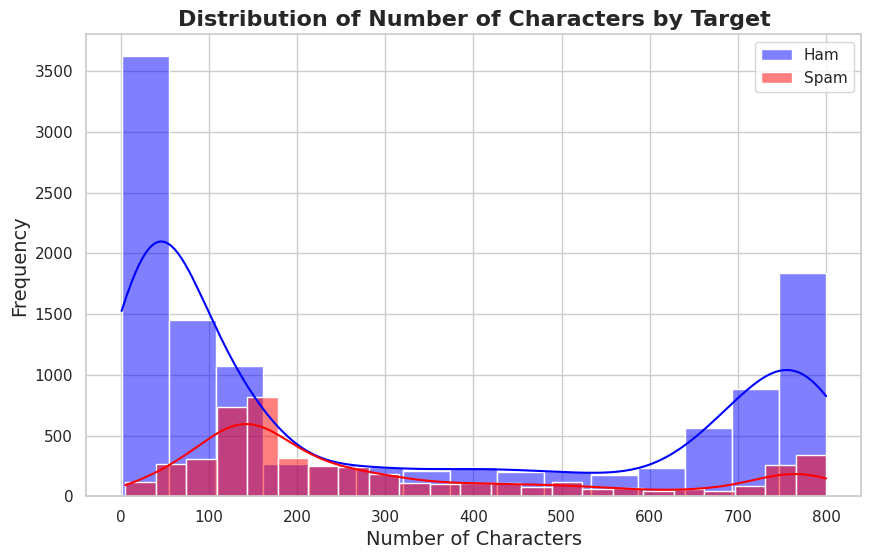

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.histplot(df_train_clean[df_train_clean['text_type'] == 0]['number_characters'], color='blue', label='Ham', kde=True)

sns.histplot(df_train_clean[df_train_clean['text_type'] == 1]['number_characters'], color='red', label='Spam', kde=True)

plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')

plt.legend()

plt.show()

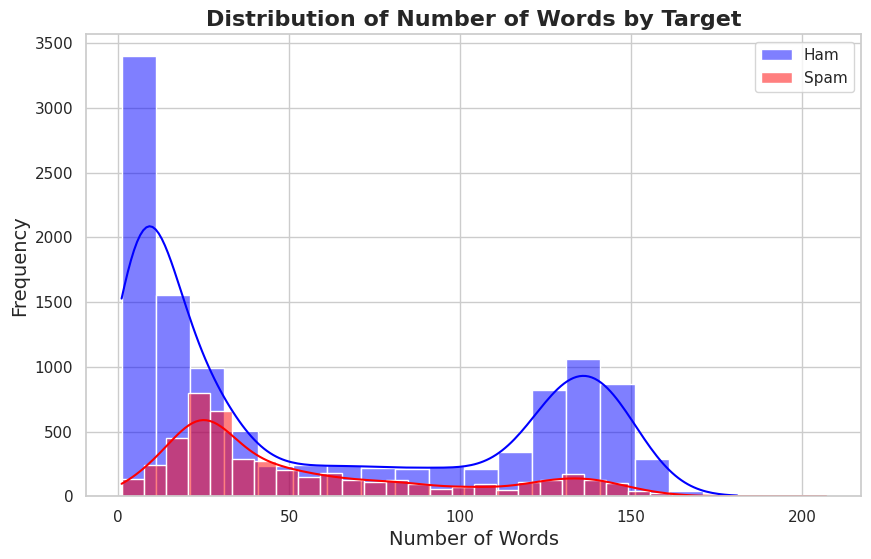

In [93]:
plt.figure(figsize=(10, 6))

sns.histplot(df_train_clean[df_train_clean['text_type'] == 0]['number_words'], color='blue', label='Ham', kde=True)

sns.histplot(df_train_clean[df_train_clean['text_type'] == 1]['number_words'], color='red', label='Spam', kde=True)

plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')

plt.legend()

plt.show()

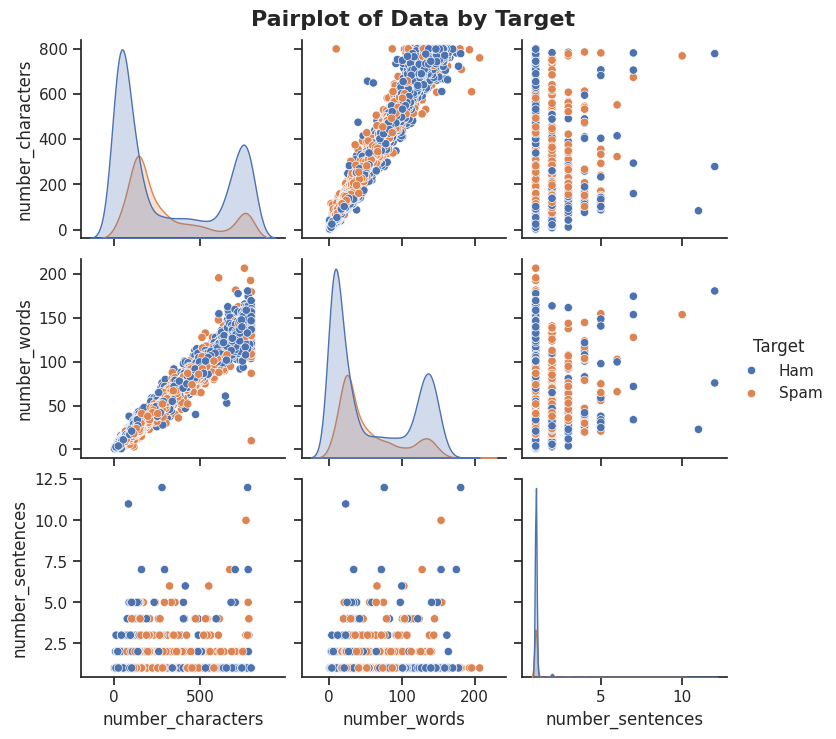

In [107]:
# Попарные графики

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.pairplot(df_train_clean, hue='text_type')

g.fig.suptitle("Pairplot of Data by Target", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.94)
g._legend.set_title('Target')
for t, l in zip(g._legend.texts, ["Ham", "Spam"]):
    t.set_text(l)
plt.show()

In [102]:
# Матрица корреляций
corr = df_train_clean[['text_type','number_characters', 'number_words', 'number_sentences']].corr()
corr.style.background_gradient(cmap='coolwarm')

,text_type,number_characters,number_words,number_sentences
text_type,1.000000,-0.020505,-0.035967,0.095214
number_characters,-0.020505,1.000000,0.991543,-0.047247
number_words,-0.035967,0.991543,1.000000,-0.032054
number_sentences,0.095214,-0.047247,-0.032054,1.000000


# Preprocessing

In [120]:
from nltk.stem.porter import PorterStemmer
import re
import string

ps = PorterStemmer()

def preprocessing_text(text):
    # Приведем текст к нижнему регистру
    text = text.lower()

    # Удаление URL
    re_url = re.compile('https?://\S+|www\.\S+')
    text=re_url.sub('', text)

    # Используем простой токенизатор NLTK - разбиение на слова и знаки препинания
    text = nltk.word_tokenize(text)

    # Удаляем специальные символы
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # Удаление стоп-слов и знаков пунктуации
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Stemming используя Porter Stemmer
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [ ]:
df_train_clean['preprocess_text'] = df_train_clean['text'].apply(preprocessing_text)

In [122]:
df_train_clean['number_words_after_transformation'] = df_train_clean['preprocess_text'].apply(lambda x: len(x.split()))
df_train_clean[['text_type','text','preprocess_text','number_words','number_words_after_transformation']].head()

<ipython-input-122-cd8be05cbc02>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,text_type,text,preprocess_text,number_words,number_words_after_transformation
0,0,make sure alex knows his birthday is over in f...,make sure alex know birthday fifteen minut far...,16,10
1,0,a resume for john lavorato thanks vince i will...,resum john lavorato thank vinc get move right ...,97,64
2,1,plzz visit my website moviesgodml to get all m...,plzz visit websit moviesgodml get movi free al...,22,13
3,1,urgent your mobile number has been awarded wit...,urgent mobil number award prize guarante call ...,23,15
4,0,overview of hr associates analyst project per ...,overview hr associ analyst project per david r...,127,99


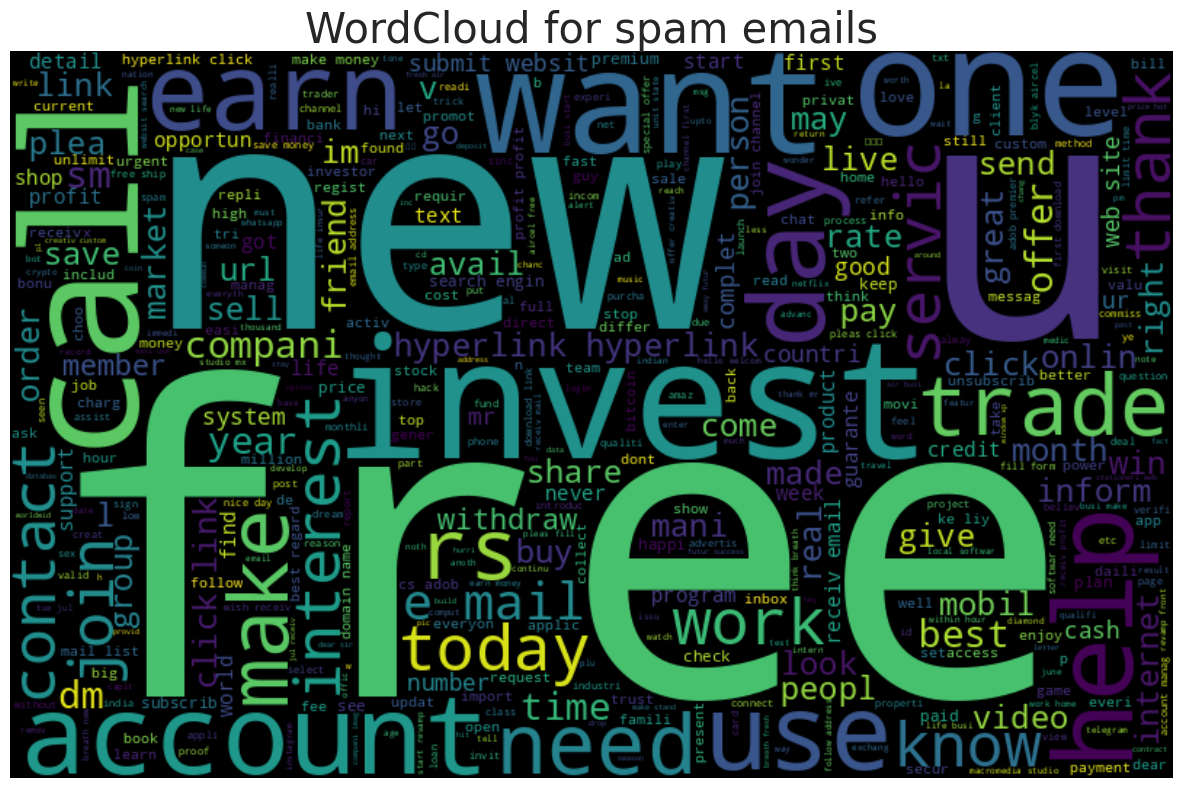

In [116]:
# Спам-сообщения

text = " ".join(df_train_clean[df_train_clean['text_type'] == 1]['preprocess_text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for spam emails', fontsize=30)
plt.axis('off')
plt.show()

In [126]:
import plotly.express as px
from collections import Counter

spam_carpos = []
for sentence in df_train_clean[df_train_clean['text_type'] == 1]['preprocess_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)
df_stat = pd.DataFrame(Counter(spam_carpos).most_common(25), columns= ['Word', 'Frequency'])

fig = px.bar(
    df_stat,
    x="Frequency",
    y="Word",
    title='Common Words in SPAM',
    width=700,
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlGnBu',  # Specify a color scale
)
fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title=None,  # Remove the y-axis title
    title_font=dict(size=40),  # Increase title font size
    font=dict(size=20),  # Increase general text font size
)


fig.update_xaxes(showgrid=False)  # Hide x-axis grid lines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')  # Show and style y-axis grid lines

fig.show()

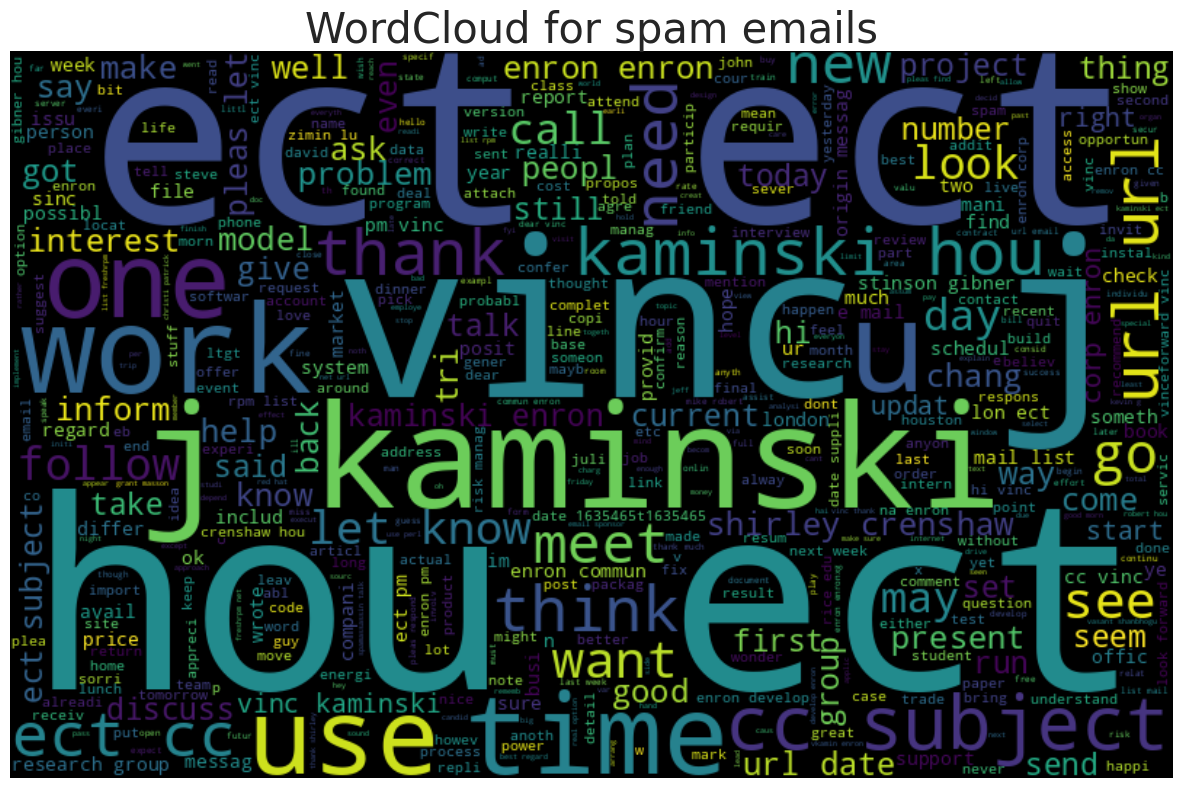

In [124]:
# Нейтральные сообщения

text = " ".join(df_train_clean[df_train_clean['text_type'] == 0]['preprocess_text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for ham emails', fontsize=30)
plt.axis('off')
plt.show()

In [127]:
spam_carpos = []
for sentence in df_train_clean[df_train_clean['text_type'] == 0]['preprocess_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)
df_stat = pd.DataFrame(Counter(spam_carpos).most_common(25), columns= ['Word', 'Frequency'])

fig = px.bar(
    df_stat,
    x="Frequency",
    y="Word",
    title='Common Words in HAM',
    width=700,
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlGnBu',  # Specify a color scale
)
fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title=None,  # Remove the y-axis title
    title_font=dict(size=40),  # Increase title font size
    font=dict(size=20),  # Increase general text font size
)


fig.update_xaxes(showgrid=False)  # Hide x-axis grid lines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')  # Show and style y-axis grid lines

fig.show()

# Эксперементы

### Подготовка данных

In [128]:
from sklearn.model_selection import train_test_split

X = df_train_clean["preprocess_text"]
y = df_train_clean['text_type'].values

#Стратифицируем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [129]:
from sklearn.feature_extraction.text import  TfidfVectorizer

tfidf = TfidfVectorizer(max_features= 3000, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

# Запуск эксперементов

In [131]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.5 MB/s eta 0:00:00


In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [138]:
svc = SVC(kernel= "sigmoid", gamma  = 1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 42 )
xgb  = XGBClassifier(n_estimators = 50, random_state = 42)
catb = CatBoostClassifier(verbose=0,random_state = 42)

In [139]:
clfs = {
    'SVC': svc,
    'KNN': knc,
    'NB': mnb,
    'LR': lrc,
    'RF': rfc,
    'xgb': xgb,
    'catb':catb}

In [142]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
def train_classifier(clfs, X_train, y_train, X_test, y_test):
    clfs.fit(X_train,y_train)
    y_pred = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy , precision,roc_auc

In [ ]:
accuracy_scores = []
precision_scores = []
auc_score_scores = []
for name , clfs in clfs.items():
    current_accuracy, current_precision,current_auc_score = train_classifier(clfs, X_train, y_train, X_test, y_test)
    print()
    print("For: ", name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("ROC_AUC: ", current_auc_score)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    auc_score_scores.append(current_auc_score)

In [ ]:
catb.fit(X_train,y_train)

In [ ]:
df_test['preprocess_text'] = df_test['text'].apply(preprocessing_text)
data_test=tfidf.transform(df_test['preprocess_text']).toarray()
df_test['score']=catb.predict(data_test)

**Вывод:** видно, что лучшее качество показала модель CatBoost